In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import ast
import warnings

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *
from ModelSelection import *


%matplotlib inline

In [2]:
cup_df = pd.read_csv(
    '../data/ML-CUP23-TR.csv',
    index_col=0,
    comment='#',
    header=None,
    names=['feature_' + str(i+1) for i in range(10)] + ['target_' + str(i+1) for i in range(3)]
)

data_set = cup_df.values
len_data = len(data_set)
np.random.shuffle(data_set)

training_len = int(0.8*len_data)

training_set = data_set[:int(training_len)] # Training Set for KFold Cross Validation
test_set = data_set[int(training_len):] # Hold Out Test Set

TR_OUTPUT = 3
TR_INPUT = data_set.shape[1] - TR_OUTPUT

scaler_out = StandardScaler()
scaler_in = StandardScaler()
scaler_in.fit(training_set[:,:TR_INPUT])
scaler_out.fit(training_set[:,TR_INPUT:])

tr_normalized = np.empty((training_len, TR_OUTPUT + TR_INPUT))
tr_normalized[:,:TR_INPUT] = scaler_in.transform(training_set[:,:TR_INPUT])
tr_normalized[:,TR_INPUT:] = scaler_out.transform(training_set[:,TR_INPUT:])

test_normalized = np.empty((len_data - training_len, TR_OUTPUT + TR_INPUT))
test_normalized[:,:TR_INPUT] = scaler_in.transform(test_set[:,:TR_INPUT])
test_normalized[:,TR_INPUT:] = scaler_out.transform(test_set[:,TR_INPUT:])

In [3]:
tr_normalized[-200:].shape

(200, 13)

In [4]:
cup_df.head(1)

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
1   0.997196   0.519527   0.974432   0.598556  -0.879758   0.334482   

   feature_7  feature_8  feature_9  feature_10   target_1  target_2   target_3  
1  -0.756348   0.993122    0.49189   -0.998804 -63.792583 -2.934901  16.971317

In [5]:
columns_order = ['topology',
 'batch_size',
 'min_epochs',
 'max_epochs',
 'patience',
 'error_increase_tolerance',
 'lambda_tikhonov',
 
 'learning_rate',
 'alpha_momentum',
 'lr_decay_tau',
 
 'adamax',
 'adamax_learning_rate',
 'exp_decay_rate_1',
 'exp_decay_rate_2',
 
 'mean_mean_euclidean_error',
 'mean_mean_squared_error',
 'var_mean_euclidean_error',
 'var_mean_squared_error',
 'mean_best_validation_training_error']

In [6]:
results_files = ['2l_relu_1.csv', '1l_sigmoid_1.csv', '1l_tanh_1.csv']
topologies = ['12_12_relu', '32_sigmoid', '32_tanh']

topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    
    dummy = pd.read_csv('../data/gs_data/' + f)
    topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
    dummy['topology'] = topologies[i]
    dummy.drop(['stats'], axis=1, inplace=True)
    
    gs_results.append(dummy)
    


orig_df = pd.concat(gs_results)
orig_df = orig_df[columns_order]

order_by = 'mean_mean_euclidean_error'
orig_df.sort_values(by=[order_by], inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.copy()

In [7]:
def remove_useless_val(x):
    if x['adamax']:
        x['learning_rate'] = None
        x['lr_decay_tau'] = None
        x['alpha_momentum'] = None
    else:
        x['adamax_learning_rate'] = None
        x['exp_decay_rate_1'] = None
        x['exp_decay_rate_2'] = None      
    return x

In [8]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
gs_results = gs_results.apply(remove_useless_val, axis=1)
#warnings.simplefilter(action='default', category=FutureWarning)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [9]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [10]:
gs_results.sample(10)

topology  batch_size  min_epochs  max_epochs  patience  \
33   32_sigmoid        40.0       100.0       600.0       8.0   
131  12_12_relu        20.0       100.0       600.0       8.0   
132  12_12_relu        20.0       100.0       600.0       8.0   
34      32_tanh        40.0       100.0       600.0       8.0   
2       32_tanh        20.0       100.0       600.0       8.0   
185  12_12_relu        40.0       100.0       600.0       8.0   
15   32_sigmoid        20.0       100.0       600.0       8.0   
75   32_sigmoid        40.0       100.0       600.0       8.0   
85   12_12_relu        40.0       100.0       600.0       8.0   
30   32_sigmoid        20.0       100.0       600.0       8.0   

     error_increase_tolerance  lambda_tikhonov  learning_rate  alpha_momentum  \
33                    0.00001          0.00010           0.20            0.10   
131                   0.00001          0.00010           0.10            0.50   
132                   0.00001          0.00010           0.02            0.50   
34                    0.00001          0.00010           0.10            0.50   
2                     0.00001          0.00001           0.20            0.10   
185                   0.00001          0.00100           0.02            0.75   
15                    0.00001          0.00001           0.10            0.10   
75                    0.00001          0.00001           0.01            0.10   
85                    0.00001          0.00010            NaN             NaN   
30                    0.00001          0.00001            NaN             NaN   

     lr_decay_tau  adamax  adamax_learning_rate  exp_decay_rate_1  \
33          250.0     0.0                   NaN               NaN   
131         250.0     0.0                   NaN               NaN   
132         250.0     0.0                   NaN               NaN   
34          250.0     0.0                   NaN               NaN   
2           250.0     0.0                   NaN               NaN   
185         250.0     0.0                   NaN               NaN   
15          250.0     0.0                   NaN               NaN   
75          250.0     0.0                   NaN               NaN   
85            NaN     1.0                  0.30              0.70   
30            NaN     1.0                  0.07              0.95   

     exp_decay_rate_2  mean_mean_euclidean_error  mean_mean_squared_error  \
33                NaN                   0.370845                 0.173436   
131               NaN                   1.497361                 2.498705   
132               NaN                   1.502206                 2.519572   
34                NaN                   0.371159                 0.171524   
2                 NaN                   0.240128                 0.074387   
185               NaN                   1.676093                 3.022155   
15                NaN                   0.309554                 0.123438   
75                NaN                   0.585215                 0.421878   
85              0.999                   0.748066                 0.696007   
30              0.999                   0.359246                 0.163769   

     var_mean_euclidean_error  var_mean_squared_error  \
33                   0.000789            5.876345e-04   
131                  0.048411            3.859748e-01   
132                  0.006906            5.930095e-02   
34                   0.000452            4.092740e-04   
2                    0.000135            3.825998e-05   
185                  0.000596            8.847727e-03   
15                   0.000006            5.380768e-07   
75                   0.002377            6.233278e-03   
85                   0.000191            1.950453e-03   
30                   0.000426            4.558065e-04   

     mean_best_validation_training_error  
33                              0.138139  
131                             2.517814  
132                             2.

In [11]:
error_treshold = 10
gs_results_clean = gs_results.loc[(gs_results['mean_mean_euclidean_error'].notna()) & (gs_results['mean_mean_euclidean_error'] < error_treshold)].copy()


gs_results_clean = gs_results_clean.reset_index(drop=True)
gs_results_clean.style.background_gradient(cmap='Blues')

In [12]:
minmaxsc = MinMaxScaler()
std_gs_results_clean = pd.DataFrame(data=minmaxsc.fit_transform(gs_results_clean[numerical_col]), columns=numerical_col)

In [13]:

def plot_gs(df, title):
    
    maps = {'adamax optimizer': adamax_opt_col,
            'standard optimizer': st_opt_col,
            'general': general_col,
            'metrics': metrics_col,
    }
    # groups and trace visibilities
    group = []
    vis = []
    visList = []
    for m in maps.keys():
        for col in numerical_col:
            if col in maps[m]:
                vis.append(True)
            else:
                vis.append(False)
        group.append(m)
        visList.append(vis)
        vis = []

    
    fig = px.line(df, title=title)
    #fig.update_layout(xaxis_range=[0, last_index])
    fig.update_yaxes(showticklabels=False)
    fig.update_traces(mode="markers+lines", hovertemplate=None)
    fig.update_layout(hovermode="x unified")

    # buttons for each group
    buttons = []
    for i, g in enumerate(group):
        button =  dict(label=g,
                    method = 'restyle',
                        args = ['visible',visList[i]])
        buttons.append(button)

    buttons = [{'label': 'all',
                    'method': 'restyle',
                    'args': ['visible', [True, True, True, True, True, True]]}] + buttons
    fig.update_layout(
        updatemenus=[
            dict(
            type="dropdown",
            direction="down",
            buttons = buttons)
        ],
    )   

    return fig

In [14]:
plot_gs(std_gs_results_clean.iloc[:10], 'GridSearch normalized values')

In [15]:
plot_gs(gs_results_clean[numerical_col].iloc[:10], 'GridSearch values')

In [16]:
orig_df

topology  batch_size  min_epochs  max_epochs  patience  \
0       32_tanh          20         100         600         8   
1       32_tanh          20         100         600         8   
2       32_tanh          20         100         600         8   
3    32_sigmoid          20         100         600         8   
4    32_sigmoid          20         100         600         8   
..          ...         ...         ...         ...       ...   
195  32_sigmoid          40         100         600         8   
196     32_tanh          40         100         600         8   
197  12_12_relu          40         100         600         8   
198  12_12_relu          20         100         600         8   
199  12_12_relu          40         100         600         8   

     error_increase_tolerance  lambda_tikhonov  learning_rate  alpha_momentum  \
0                     0.00001          0.00001            0.1            0.90   
1                     0.00001          0.00001            0.2            0.50   
2                     0.00001          0.00001            0.2            0.10   
3                     0.00001          0.00001            0.2            0.50   
4                     0.00001          0.00001            0.1            0.90   
..                        ...              ...            ...             ...   
195                   0.00001          0.00001            0.1            0.50   
196                   0.00001          0.00010            0.2            0.10   
197                   0.00001          0.00100            0.2            0.75   
198                   0.00001          0.00100            0.2            0.50   
199                   0.00001          0.00010            0.1            0.50   

     lr_decay_tau  adamax  adamax_learning_rate  exp_decay_rate_1  \
0             250   False                 0.002              0.90   
1             250   False                 0.002              0.90   
2             250   False                 0.002              0.90   
3             250   False                 0.002              0.90   
4             250   False                 0.002              0.90   
..            ...     ...                   ...               ...   
195             0    True                 0.010              0.95   
196           250   False                 0.002              0.90   
197           250   False                 0.002              0.90   
198           250   False                 0.002              0.90   
199           250   False                 0.002              0.90   

     exp_decay_rate_2  mean_mean_euclidean_error  mean_mean_squared_error  \
0               0.999               2.104981e-01             5.912509e-02   
1               0.999               2.135609e-01             6.200720e-02   
2               0.999               2.401283e-01             7.438714e-02   
3               0.999               2.525208e-01             8.151765e-02   
4               0.999               2.668472e-01             9.173618e-02   
..                ...                        ...                      ...   
195             0.999               2.582184e+00             7.541152e+00   
196             0.999               7.971035e+00             2.807446e+02   
197             0.999               3.236442e+20             3.142366e+41   
198             0.999              2.714430e+117            2.210440e+235   
199             0.999                        NaN                      NaN   

     var_mean_euclidean_error   var_mean_squared_error  \
0                8.724836e-06                 0.000005   
1                4.066554e-04                 0.000076   
2                1.352074e-04                 0.000038   
3                4.890832e-04                 0.000189   
4                2.135949e-04                 0.000093   
..                        ...                      ...   
195              3.291465e-02                 1.063505   
196              6.067539e+01      

In [17]:
#  best performance
interesting_index = list(orig_df['topology'].drop_duplicates().index)
orig_df.iloc[interesting_index]

topology  batch_size  min_epochs  max_epochs  patience  \
0      32_tanh          20         100         600         8   
3   32_sigmoid          20         100         600         8   
63  12_12_relu          20         100         600         8   

    error_increase_tolerance  lambda_tikhonov  learning_rate  alpha_momentum  \
0                    0.00001          0.00001            0.1             0.9   
3                    0.00001          0.00001            0.2             0.5   
63                   0.00001          0.00010            0.1             0.5   

    lr_decay_tau  adamax  adamax_learning_rate  exp_decay_rate_1  \
0            250   False                 0.002               0.9   
3            250   False                 0.002               0.9   
63             0    True                 0.500               0.8   

    exp_decay_rate_2  mean_mean_euclidean_error  mean_mean_squared_error  \
0              0.999                   0.210498                 0.059125   
3              0.999                   0.252521                 0.081518   
63             0.999                   0.486868                 0.310954   

    var_mean_euclidean_error var_mean_squared_error  \
0                   0.000009               0.000005   
3                   0.000489               0.000189   
63                  0.003394   0.004850520061442022   

    mean_best_validation_training_error  
0                              0.049554  
3                              0.077012  
63                             0.242295

In [18]:
#  potentially interesting
interesting_index += list(orig_df.sort_values(['mean_best_validation_training_error'])['topology'].drop_duplicates().index)

In [19]:
interesting_index = list(set(interesting_index))
interesting_index

[0, 73, 3, 63]

In [20]:
def train_from_index(df, tr_set, val_set, index, topologies_dict):
    default_values =  {
        'training_set': None, 
        'validation_set': None,
        'metrics':[ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error],      
        'topology': None,
        
        'range_min' : -0.75,
        'range_max' : 0.75,
        'fan_in' : True,
        'random_state' : None,

        'lambda_tikhonov' : 0.00001,
        
        'learning_rate' : 0.1,
        'alpha_momentum' : 0.5,
        'lr_decay_tau' : 250,
        #'eta_tau' : 0.01,
        'nesterov' : False,
        
        'adamax': False,
        'adamax_learning_rate': 0.002,
        'exp_decay_rate_1':0.9,
        'exp_decay_rate_2':0.999,
        
        'batch_size' : 5,
        'min_epochs' : 25,
        'max_epochs' : 500,
        'patience' : 5,
        'error_increase_tolerance' : 0.0001,
        'retraing_es_error': -1,
        
        'collect_data':True, 
        'collect_data_batch':False, 
        'verbose':True,
        }
    
    for i in df.columns:
        if i in default_values:
            default_values[i] = df.iloc[index][i]
    
    # set critical values
    default_values['learning_rate'] = default_values['learning_rate'] / default_values['batch_size']
    default_values['adamax_learning_rate'] = default_values['adamax_learning_rate'] / default_values['batch_size']
    default_values['eta_tau'] = default_values['learning_rate']/100 # eta tau more or less 1% of eta_0
    default_values['lr_decay_tau'] = default_values['lr_decay_tau'] * (len(data_set)/default_values['batch_size'])
    default_values['topology'] = topologies_dict[df.iloc[index]['topology']]
    default_values['training_set'] = tr_set
    default_values['validation_set'] = val_set
    
    default_values['retraing_es_error'] = df.iloc[index]['stats']['best_validation_training_error']
    
    
    train_args = [default_values[key] for key in NeuralNetwork.train_input] 
    
    # create a new model
    NN = NeuralNetwork(default_values['topology'], default_values['range_min'], default_values['range_max'], default_values['fan_in'], default_values['random_state'])
    # train the model
    stats = NN.train(*train_args)
    return [NN, stats]
    

In [21]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [22]:
interesting_model = []
for i in interesting_index:
    
    dummy = {}
    dummy['nn_file_name'] = '../data/net/' + orig_df.iloc[i]['topology'] + '_' + str(i) + '.json'
    dummy['index'] = i
    nn, stats = train_from_index(orig_df, tr_normalized[:-250], tr_normalized[-250:], i, topologies_dict)
    dummy['model'] = nn
    dummy['stats'] = stats
    dummy['top_name'] = orig_df.iloc[i]['topology']
    
    dummy['std_prediction_tr'] = nn.predict_array(tr_normalized[:-250,:TR_INPUT])
    dummy['std_prediction_val'] = nn.predict_array(tr_normalized[-250:,:TR_INPUT])
    dummy['std_prediction_test'] = nn.predict_array(test_normalized[:,:TR_INPUT])
    
    dummy['prediction_tr'] = scaler_out.inverse_transform(dummy['std_prediction_tr'])
    dummy['prediction_val'] = scaler_out.inverse_transform(dummy['std_prediction_val'])
    dummy['prediction_test'] = scaler_out.inverse_transform(dummy['std_prediction_test'])
        
    dummy['std_tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_tr'], tr_normalized[:-250,TR_INPUT:])
    dummy['std_val_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_val'], tr_normalized[-250:,TR_INPUT:])
    dummy['std_test_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_test'], test_normalized[:,TR_INPUT:])
    
    dummy['tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_tr'], training_set[:-250,TR_INPUT:])
    dummy['val_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_val'], training_set[-250:,TR_INPUT:])
    dummy['test_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_test'], test_set[:,TR_INPUT:])
    interesting_model.append(dummy)


starting values:  {'training_set_len': 550, 'minibatch_size': 20, 'max_epochs': 600, 'retraing_es_error': -1, 'error_increase_tolerance': 1e-05, 'patience': 8, 'min_epochs': 100, 'learning_rate': 0.005, 'lr_decay_tau': 12500.0, 'eta_tau': 5e-05, 'lambda_tikhonov': 1e-05, 'alpha_momentum': 0.9, 'nesterov': False, 'adamax': False, 'adamax_learning_rate': 0.0001, 'exp_decay_rate_1': 0.9, 'exp_decay_rate_2': 0.999, 'best_validation_training_error': inf, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999997), 'mean_epoch_train_time': 0, 'units_weights': {41: [], 40: [], 39: [], 38: [], 37: [], 36: [], 35: [], 34: [], 33: [], 32: [], 31: [], 30: [], 29: [], 28: [], 27: [], 26: [], 25: [], 24: [], 23: [], 22: [], 21: [], 20: [], 19: [], 18: [], 17: [], 16: [], 15: [], 14: [], 13: [], 12: [], 11: [], 10: [], 44: [], 43: [], 42: []}, 'units_weights_batch': {}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'training_mean_euclide

[1/600] tr time: 0:00:01.181547 | mean_squared_error: tr=2.6123735114263544 val=2.772203083169807 | | mean_euclidean_error: tr=1.5050450841689402 val=1.561275641276624 | 
[2/600] tr time: 0:00:01.068256 | mean_squared_error: tr=4.30823306016412 val=3.924309998352381 | | mean_euclidean_error: tr=1.8365331665669686 val=1.7432994109401212 | 
[3/600] tr time: 0:00:01.145823 | mean_squared_error: tr=1.029795306978965 val=1.011251754397878 | | mean_euclidean_error: tr=0.9381264992807223 val=0.9342749640023157 | 
[4/600] tr time: 0:00:01.175655 | mean_squared_error: tr=1.013189844859166 val=1.1318325339003728 | | mean_euclidean_error: tr=0.8928677480444713 val=0.9531614526452536 | 
[5/600] tr time: 0:00:01.218112 | mean_squared_error: tr=0.8336647149115315 val=0.80328068437713 | | mean_euclidean_error: tr=0.8346172431134413 val=0.8168539379221232 | 
[6/600] tr time: 0:00:01.061133 | mean_squared_error: tr=0.4390149686073658 val=0.43373762485577505 | | mean_euclidean_error: tr=0.60224666886088

In [23]:
with open('../data/net/models.json', 'w+') as file:
    save_obj(interesting_model, file)

In [24]:
interesting_model = load_obj('../data/net/models.json')

In [26]:
for dummy in interesting_model:
    
    dummy['std_prediction_tr'] = dummy['model'].predict_array(tr_normalized[:-250,:TR_INPUT])
    dummy['std_prediction_val'] = dummy['model'].predict_array(tr_normalized[-250:,:TR_INPUT])
    dummy['std_prediction_test'] = dummy['model'].predict_array(test_normalized[:,:TR_INPUT])
    
    dummy['prediction_tr'] = scaler_out.inverse_transform(dummy['std_prediction_tr'])
    dummy['prediction_val'] = scaler_out.inverse_transform(dummy['std_prediction_val'])
    dummy['prediction_test'] = scaler_out.inverse_transform(dummy['std_prediction_test'])
    
    dummy['std_tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_tr'], tr_normalized[:-250,TR_INPUT:])
    dummy['std_val_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_val'], tr_normalized[-250:,TR_INPUT:])
    dummy['std_test_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_test'], test_normalized[:,TR_INPUT:])
    
    dummy['tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_tr'], training_set[:-250,TR_INPUT:])
    dummy['val_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_val'], training_set[-250:,TR_INPUT:])
    dummy['test_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_test'], test_set[:,TR_INPUT:])

In [27]:
df_im = pd.DataFrame(interesting_model)
def take_data(x):
    cols = ['training_mean_squared_error','validation_mean_squared_error','training_mean_euclidean_error','validation_mean_euclidean_error']
    cols_name = ['tmse','vmse','tmee','vmee']
    for i, c in enumerate(cols):
        x[cols_name[i]] = x['stats'][c]
        
    x['best_validation_training_error'] = x['stats']['best_validation_training_error']
    return x
df_im.columns

Index(['nn_file_name', 'index', 'model', 'stats', 'top_name',
       'std_prediction_tr', 'std_prediction_val', 'std_prediction_test',
       'prediction_tr', 'prediction_val', 'prediction_test', 'std_tr_error',
       'std_val_error', 'std_test_error', 'tr_error', 'val_error',
       'test_error'],
      dtype='object')

In [29]:
df_im = df_im.apply(take_data, axis=1)
df_im = df_im.drop(['stats'], axis=1)

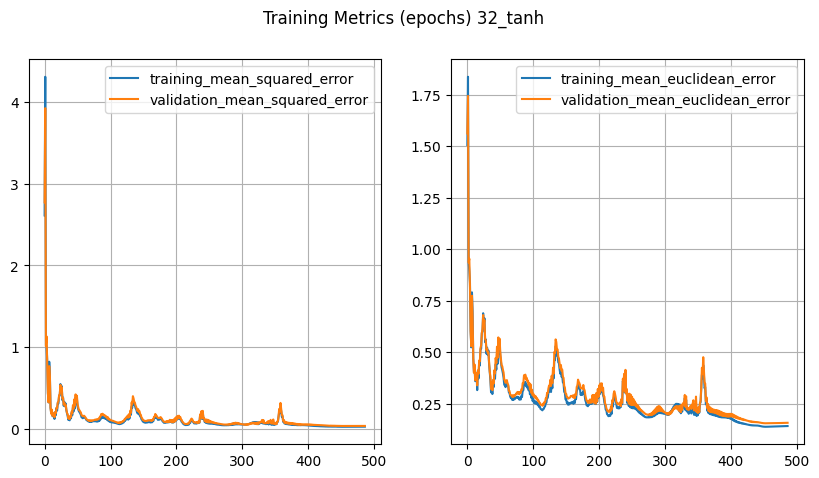

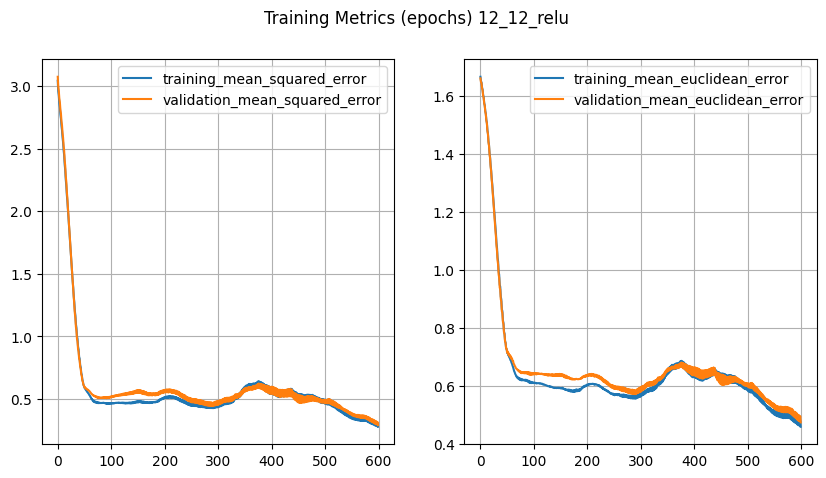

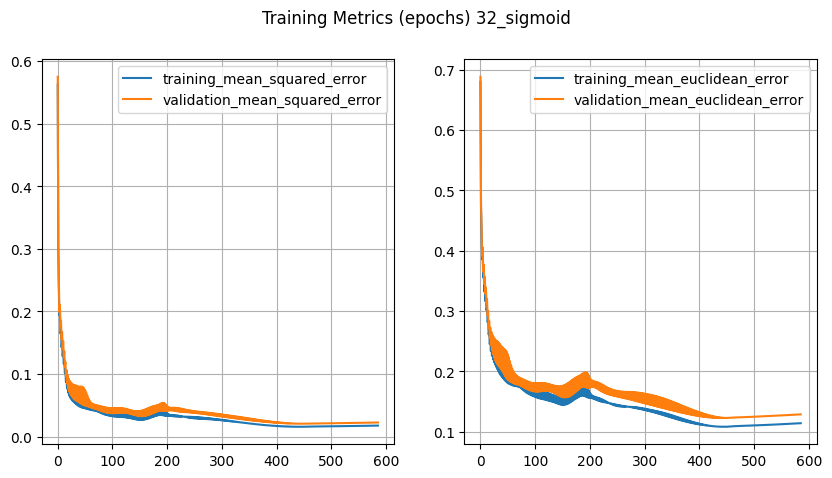

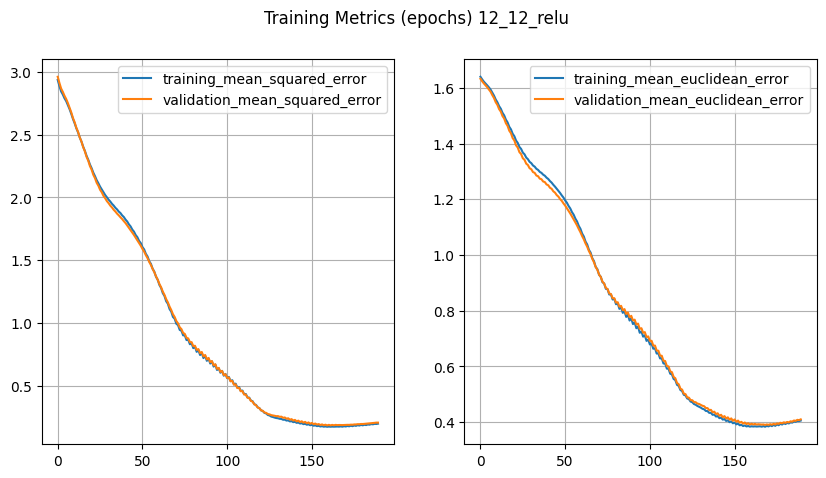

In [30]:
metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error]
for dummy in interesting_model:
    stats = dummy['stats']
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Training Metrics (epochs) ' + dummy['top_name'])
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['training_' + metrics[i].__name__, 'validation_' + metrics[i].__name__],
                ax=ax[i])

In [32]:
dic_list = []
for dummy in interesting_model:
    dic = {}
    dic[dummy['top_name'] + 'tmse'] = dummy['stats']['training_mean_squared_error']
    dic[dummy['top_name'] + 'vmse'] = dummy['stats']['validation_mean_squared_error']
    dic[dummy['top_name'] + 'tmee'] = dummy['stats']['training_mean_euclidean_error']
    dic[dummy['top_name'] + 'vmee'] = dummy['stats']['validation_mean_euclidean_error']
    dic_list.append(pd.DataFrame(dic))
    
for i in dic_list:
    fig = px.line(i)
    fig.show()

In [33]:
'''for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights')'''

"for unit_index in stats['units_weights'].keys():\n    vals = np.array(stats['units_weights'][unit_index]).T\n    multy_plot(vals, \n               ['weight_' + str(i) for i in range(len(vals))], \n               'Unit ' + str(unit_index) + ' Weights')"